In [1]:
import gym
import subprocess
import time
import numpy as np
from collections import defaultdict
import msgpack
import os
import pickle
import pybullet
from pybullet_utils.bullet_client import BulletClient
from udp_server import UDPServer
from operator import itemgetter

def linearMinMaxConversionCoefficient(a,b,c,d):
    """
    linear conversion from [a,b] to [c,d] using y = kx + m,
    return coefficient k,m
    """
    k = (d - c)/(b-a)
    m = c - a*k
    return k,m

def linearMapFcn(a,b,c,d):
    """
    return a function of the linear conversion from 
    [a,b] to [c,d] using y = kx + m,
    """
    k = (d - c)/(b-a)
    m = c - a*k
    return lambda x:k*x +m


class BulletCollisionDetect:
    """
    Helper class for collision detection using pybullet
    """
    def __init__(s,gui=False,urdf_path="../../data/urdf/12dof/robot.urdf"):
        """
        load urdf and init the collision detection
        """
        try: dir_path = os.path.dirname(os.path.abspath(__file__))
        except NameError: dir_path = os.getcwd()
        urdf_path=os.path.abspath(os.path.join(dir_path,urdf_path))
        # loading using bullet_client
        # ref: https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit#
        s._p = BulletClient(pybullet.GUI if gui else pybullet.DIRECT)
        s.body_id = s._p.loadURDF(urdf_path,
                              useFixedBase=1,
                              flags=pybullet.URDF_USE_SELF_COLLISION)  # load urdf
        s.dof = s._p.getNumJoints(s.body_id)
        # JOINT_INFO_DICT = {name: i for i, name in enumerate([
        #  "jointIndex", "jointName", "jointType", "qIndex", "uIndex",
        #  "flags", "jointDamping", "jointFriction", "jointLowerLimit",
        #  "jointUpperLimit", "jointMaxForce", "jointMaxVelocity", "linkName",
        #  "jointAxis", "parentFramePos", "parentFrameOrn", "parentIndex"])}
#         joint_info = [s._p.getJointInfo(s.body_id, i) for i in range(s.dof)]
#         s.joint_lower_limit = np.asarray(
#             [j[JOINT_INFO_DICT["jointLowerLimit"]] for j in joint_info])
#         s.joint_upper_limit = np.asarray(
#             [j[JOINT_INFO_DICT["jointUpperLimit"]] for j in joint_info])
#         s.joint_range = s.joint_upper_limit-s.joint_lower_limit

    def getContactPoints(s,joint_pos):
        """get contact points info given joint position in rad
        ref:https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit#heading=h.cb0co8y2vuvc
        """
        for i in range(s.dof):
            s._p.resetJointState(s.body_id, i, joint_pos[i],0)
        s._p.performCollisionDetection()
        return s._p.getContactPoints()
        
    def __del__(s):
        s._p.disconnect()
#         print("deleted")


class FlexipodEnv(gym.Env):
    """
    openai gym compatible environment for the simulated 12DOF flexipod
    ref: https://github.com/openai/gym/blob/master/gym/core.py
    """
    # name of command message
    CMD_NAME = ("header", "t", "cmd")
    CMD_ID = defaultdict(None,{name: k  for k,name in enumerate(CMD_NAME)})
    
    UDP_TERMINATE = int(-1)
    UDP_PAUSE = int(17)
    UDP_RESUME = int(16)
    UDP_RESET = int(15)
    UDP_ROBOT_STATE_REPORT = int(14)
    UDP_MOTOR_VEL_COMMEND = int(13)
    UDP_STEP_MOTOR_VEL_COMMEND = int(12)
    UDP_MOTOR_POS_COMMEND = int(11)
    UDP_STEP_MOTOR_POS_COMMEND = int(10)
    
    
    def __init__(
        s, # self
        dof:int = 12, # degress of freedom of the robot
        num_observation:int=5, # number of observation in series
        num_sensors:int = 0, # num of spring strain sensors
        normalize:bool = True, # whether to normlaize the observation and action
        max_joint_vel:float = 10, # maximum joint velocity rad/s
        humanoid_task:bool = True, # if true, humanoid, else qurdurped
        max_episode_steps:int = 2000,
        max_action:float = 5, # [rad/s], velocity control
        flatten_obs:bool = True, # whether to flatten observation
        info = False, # bool flag to send extra information when processing messages
        local_address = ("127.0.0.1",33300),
        remote_address = ("127.0.0.1",33301),
        robot_folder:str = "../../robot/v11" # root folder for the robot
        ):
        super().__init__() # init gym env
        
        # collision detection with pybullet
        s.cd = BulletCollisionDetect(urdf_path=robot_folder+"/urdf/robot.urdf") 
        
        # name of the returned message from simulation
        s.REC = np.array([
            # name,         size,         min,          max
            ("header",       1,         -32768,         32768        ),
            ("t",            1,         0,              np.inf       ), # simulation time [s]
            ("joint_pos",    dof*2,     -1.,            1.           ), # joint cos(angle) sin(angle) [rad]
            ("joint_vel",    dof,       -max_joint_vel, max_joint_vel), # joint velocity [rad/s]
            ("actuation",    dof,       -1.,            1.           ), # joint actuation [-1,1]
            ("orientation",  6,         -1.,            1.           ), # base link (body) orientation
            ("ang_vel",      3,         -30.,           30.          ), # base link (body) angular velocity [rad/s]
            ("com_acc",      3,         -30.,           30.          ), # base link (body) acceleration
            ("com_vel",      3,         -2.,            2.           ), # base link (body) velocity
            ("com_pos",      3.,        -1.,            1.           ), # base link (body) position
            ("constraint", dof+1,         0,            1            ), # selected constraint_force/total_weight
            ("spring_strain",num_sensors,-0.005,       0.005         ), # selected spring strain
        ],dtype=[('name', 'U20'), ('size', 'i4'), ('min', 'f4'),('max', 'f4')])
        
        s.sensor_id = (9,12) # left_foot, right_foot, index of the mass part id
        s.sensor_distance = 100  # distance to joint TODO need to change here..
        
        # selected observation
        OBS_DICT = { # dictionary is ordered since python 3.6
            "joint_pos":None,                    #0
            "joint_vel":None,                    #1
            "actuation":None,                    #2
            "orientation":None,                  #3
            "ang_vel":None,                      #4
            "com_acc":None,                      #5
            "com_vel":None,                      #6
            "com_pos":(2,), # com-z              #7
            "constraint":s.sensor_id,            #8
            "spring_strain":None,                #9
        }
        
        s.humanoid_task = humanoid_task
            
        s.dof = dof # num joints
        s.num_observation = num_observation
        s.normalize = normalize
        s.flatten_obs = flatten_obs # True
        s.info = info # bool flag to send info
        s._max_episode_steps = max_episode_steps # maximum episode steps
        
        s.joint_pos = np.empty(dof,dtype=np.float32) # joint position [rad]
        s.episode_steps = 0 # curret step in an episode

        s.ID =defaultdict(None,{name: k  for k,name in enumerate(s.REC["name"])})
        s.ID_t = s.ID['t']
        s.ID_joint_pos = s.ID['joint_pos']
        s.ID_joint_vel = s.ID['joint_vel']
        s.ID_actuation = s.ID['actuation']
        s.ID_orientation = s.ID['orientation']
        s.ID_com_vel = s.ID['com_vel']
        s.ID_com_acc = s.ID['com_acc']
        s.ID_com_pos = s.ID['com_pos']
        s.ID_constraint = s.ID['constraint']
        
        # TODO-> position control
        max_action = 0.2*max_action
        
        s._initObsACt(max_action,s.REC,OBS_DICT) # initialize the observation and action space
        
        # defualt packer # https://msgpack-python.readthedocs.io/en/latest/api.html#msgpack.Packer
        s.packer = msgpack.Packer(use_single_float=True, use_bin_type=True)
        
        # simulation specific commend
        s.reset_cmd_b =  s.packer.pack([s.UDP_RESET])
        s.pause_cmd_b =  s.packer.pack([s.UDP_PAUSE])
        s.resume_cmd_b = s.packer.pack([s.UDP_RESUME])
        s.close_cmd_b =  s.packer.pack([s.UDP_TERMINATE])
        
        s.server = UDPServer(local_address,remote_address)

        s._initRobotGraph(robot_folder)
        # start the simulation
        s.start()
        
        
    def _initRobotGraph(s,robot_folder):
        """initialized and load the robot graph from file"""
        if not os.path.isabs(robot_folder): # absolute path or not
            try:base_dir =  os.path.dirname(__file__) # file location
            except NameError:base_dir = os.getcwd()
            robot_folder = os.path.abspath(os.path.join(base_dir,robot_folder))
        
        _t= time.time()
        with open(f"{robot_folder}//robot.pickle","rb") as f:
            s.graph = pickle.load(f)
        print(f"Loading robot graph takes {time.time()-_t:.1f} s.")
        s.t_sensor = np.eye(4)
        s.t_sensor[:3,3] = [0,0,-s.sensor_distance] # TODO
        
        s.node_sensor = itemgetter(*s.sensor_id)(s.graph.nodes)#node_left_foot,node_right_foot
        
        # t= eye(4), world thransform equivalent to root space transfrom
        s.joint_pos = s.graph.getJointPosArrFast()
        s.graph.setJointPosArrFast(s.joint_pos) # set initial joint pos to graph.joint_pos
        s.graph.updateWorldTransformFast(np.eye(4))
        # sensor x position in the robot root space
        
        s.t_world_left_foot_sensor_x0 = (s.node_sensor[0]["world_transform"]@s.t_sensor)[0,3] # x
        s.t_world_right_foot_sensor_x0 = (s.node_sensor[1]["world_transform"]@s.t_sensor)[0,3]
        with np.printoptions(precision=2, suppress=True, threshold=5):
            print(s.t_world_left_foot_sensor_x0)
            print(s.t_world_right_foot_sensor_x0)
        
        from phase_indication import phaseIndicatorPair
        s.phase_indicator_pair_0 = phaseIndicatorPair(a=0.3, b=0.7, s=0.05, t0=0.25, t1=0.75, ys = -1., y0=0.)
        s.phase_indicator_pair_1 = phaseIndicatorPair(a=0.25, b=0.75, s=0.05, t0=0.25, t1=0.75, ys = 2., y0=-1.)
    
    def cyclicReward(s,t_normalized):
        s.graph.setJointPosArrFast(s.joint_pos)
        s.graph.updateWorldTransformFast(np.eye(4))

        # indicator for foot force
        i0_0,i0_1= s.phase_indicator_pair_0.get(t_normalized)
        # indicator for foot forward displacemnt relative to body, input to the example gait generator
        i1_0,i1_1= s.phase_indicator_pair_1.get(t_normalized) 

        # s.sensor_force
        # when left foot is raised, left foot sensor force should be 0, 
        # penalize foot force cyclically 
        c0_0 = min(1,s.sensor_force[0]) # left foot, keep max at 1
        c0_1 = min(1,s.sensor_force[1]) # right foot
        r0 = i0_0*c0_0+i0_1*c0_1
        # r0_0 = c0_0*i0_0
        # r0_1 = c0_1*i0_1

        # body_space_left_foot_sensor_pos = (s.node_sensor[0]["world_transform"]@s.t_sensor)[:3,3]
        # body_space_right_foot_sensor_pos = (s.node_sensor[1]["world_transform"]@s.t_sensor)[:3,3]
        # with np.printoptions(precision=3, suppress=True):
        #     print(body_space_left_foot_sensor_pos)
        #     print(body_space_right_foot_sensor_pos)
            
        # body space left  foot sensor forward displacement / normalizaton_coefficient
        c1_0 = -(s.node_sensor[0]["world_transform"]@s.t_sensor)[2,3]/100.
        # body space right foot sensor forward displacement / normalizaton_coefficient
        c1_1 = -(s.node_sensor[1]["world_transform"]@s.t_sensor)[2,3]/100.
        # print(f"c1_0, c1_1={c1_0:.3f},{c1_1:.3f}")
        c1_0 = max(-1,min(1,c1_0)) # clamp to [-1,1]
        c1_1 = max(-1,min(1,c1_1)) # clamp to [-1,1]
        r1 = i1_0*c1_0+i1_1*c1_1
        # r1_0 = i1_0*c1_0
        # r1_1 = i1_1*c1_1
        
        # # indicator 0
        # print(f"i0_0, i0_1={i0_0:.3f}, {i0_1:.3f}")
        # print(f"c0_0, c0_1={c0_0:.3f}, {c0_1:.3f}")
        # print(f"r0_0, r0_1={r0_0:.3f}, {r0_1:.3f}")
        # print(f"r0={r0:+5.3f}")
        # # indicator 1
        # print(f"i1_0, i1_1={i1_0:+5.3f}, {i1_1:+5.3f}")
        # print(f"c1_0, c1_1={c1_0:+5.3f},{c1_1:+5.3f} (clamp to [-1,1])")
        # print(f"r1_0, r1_1={r1_0:+5.3f}, {r1_1:+5.3f}")
        # print(f"r1={r1:+5.3f}")
        
        r_cyclic = (0.9+0.5*r0)*(0.9+0.5*r1)
        return r_cyclic
        
    def _initObsACt(s,max_action,REC,OBS_DICT):
        """helper function to initialize the observation and action space"""
        for key in list(OBS_DICT): # remove item with zero size
            if s.REC["size"][s.ID[key]]==0:
                print(f"{key} size==0, removed from OBS_DICT")
                OBS_DICT.pop(key)
        s.OBS_NAME = tuple(OBS_DICT.keys()) # keys in OBS_DICT
        s.OBS_IDS = tuple(s.ID[n] for n in s.OBS_NAME) # indices of the OBS
        s.OBS_ITEM_SLICE = tuple(OBS_DICT.values()) # indices of each item in OBS_DICT
        
        def conditional_flatten(msg_i):
            """helper to conditionally flatten a list of list"""
            flattend = []
            for item,item_slice in zip(itemgetter(*s.OBS_IDS)(msg_i),s.OBS_ITEM_SLICE):
                try: # check if item is not single number
                    len(item) # len>1
                    if item_slice is not None:
                        item = itemgetter(*item_slice)(item)
                    try:
                        len(item) # len>1
                        flattend.extend(item)# not single number
                    except TypeError: # single number
                        flattend.append(item) # single number
                except TypeError: # single number
                    flattend.append(item)
            return flattend
        s.conditional_flatten = conditional_flatten
        
        # raw min/max observation
        s.raw_min_obs = np.hstack([ # raw max observation (from simulation)
            np.ones(REC["size"][s.ID[n]] if OBS_DICT[n] is None else len(OBS_DICT[n])
                   )*REC["min"][s.ID[n]]for n in s.OBS_NAME]).astype(np.float32)
        s.raw_max_obs = np.hstack([ # raw max observation (from simulation)
            np.ones(REC["size"][s.ID[n]] if OBS_DICT[n] is None else len(OBS_DICT[n])
                   )*REC["max"][s.ID[n]]for n in s.OBS_NAME]).astype(np.float32)

        # multiple observation per network input
        s.raw_min_obs = np.tile(s.raw_min_obs,(s.num_observation,1))
        s.raw_max_obs = np.tile(s.raw_max_obs,(s.num_observation,1))
        
        
        if s.flatten_obs:# whether to flatten the observation
            s.raw_min_obs = s.raw_min_obs.ravel()
            s.raw_max_obs = s.raw_max_obs.ravel()
            
            # TODO MAKE IT CYCLIC
            s.raw_min_obs = np.append(s.raw_min_obs,[0]).astype(np.float32)
            s.raw_max_obs = np.append(s.raw_max_obs,[1]).astype(np.float32)
            
        # raw min/max action for all motors # [rad/s]
        s.raw_min_act = - max_action*np.ones(s.dof,dtype=np.float32)
        s.raw_max_act =   max_action*np.ones(s.dof,dtype=np.float32)
        
        if s.normalize: # conditionally normalize the action space
            s.action_space = gym.spaces.Box(low = - np.ones_like(s.raw_min_act),high = np.ones_like(s.raw_max_act))
            s.observation_space = gym.spaces.Box(low = - np.ones_like(s.raw_min_obs),high = np.ones_like(s.raw_max_obs))
            # action conversion from normalized to raw: y = kx + m
            s.toRawAction = linearMapFcn(-1.0,1.0,s.raw_min_act,s.raw_max_act)
            # action conversion from raw to normalized: nor - normalized
            s.toNormalizedAction = linearMapFcn(s.raw_min_act,s.raw_max_act,-1.0,1.0)            
            # observation from normalized to raw:
            s.toRawObservation = linearMapFcn(-1.0, 1.0,s.raw_min_obs,s.raw_max_obs)            
            # observation from raw to normalized:
            s.toNormalizedObservation = linearMapFcn(s.raw_min_obs,s.raw_max_obs,-1.0,1.0)
        else: # raw action and observation
            s.action_space = gym.spaces.Box(low = s.raw_min_act,high = s.raw_max_act)
            s.observation_space = gym.spaces.Box(low = s.raw_min_obs,high = s.raw_max_obs)
        
    def __del__(s): # Deleting (Calling destructor) 
        print(f'Destructor called, {s.__class__} deleted.')
#         s.close()
    
    
    # def exampleAction(s):
    #     """walking example"""
    #     pi = np.pi
    #     p_f_b0 = -pi/6 # font arm body-0
    #     p_f_01 = pi/3 # front arm 01
    #     p_f_12 = -pi/4 # front arm 12
    #     n0 = pi/90 # body incline
    #     # n0 = 0 # body incline
        
    #     n1 = pi/9.5
    #     n2 = pi/12
    #     while True:
    #         for p_bl_b0,p_br_b0 in zip([n2,n1,n2],[n1,n2,n1]):

    #             p_bl_01 = -p_bl_b0*2
    #             p_br_01 = -p_br_b0*2

    #             p_bl_12 = p_bl_b0
    #             p_br_12 = p_br_b0

    #             joint_pos = np.array([
    #                 # front left
    #                     -p_f_b0,
    #                     -p_f_01,
    #                     -p_f_12,
    #                 # front right
    #                     p_f_b0,
    #                     p_f_01,
    #                     p_f_12,
    #                 # back left
    #                     -p_bl_b0-n0,
    #                     -p_bl_01,
    #                     -p_bl_12,
    #                 #back right
    #                     p_br_b0+n0,
    #                     p_br_01,
    #                     p_br_12,
    #             ])

    #             while True:
    #                 delta_p = 1.5*(joint_pos-s.joint_pos)
    #                 if np.linalg.norm(delta_p)>4e-2:
    #                     yield delta_p
    #                 else:
    #                     break

    def exampleAction(s):
        pi = np.pi
        p_f_b0 = pi/24 # font arm body-0
        p_f_01 = pi/3 # front arm 01
        p_f_12 = -pi/12 # front arm 12
        p_b0_base = pi/8 # back leg body-0
        while True:
            # indicator for foot force
            i0_0,i0_1= s.phase_indicator_pair_0.get(s.t_normalized)
            # indicator for foot forward displacemnt relative to body, input to the example gait generator
            i1_0,i1_1= s.phase_indicator_pair_1.get(s.t_normalized)
            
            i0 = i1_0 # use phase_indicator_pair_1
            i1 = i1_1
            
            p_bl_b0 =p_b0_base+i0*0.08
            p_br_b0 =p_b0_base+i1*0.08

            p_bl_01 = -p_bl_b0*2
            p_br_01 = -p_br_b0*2

            p_bl_12 = p_bl_b0
            p_br_12 = p_br_b0

            joint_pos = np.array([
                # front left
                    -p_f_b0,
                    -p_f_01,
                    -p_f_12,
                # front right
                    p_f_b0,
                    p_f_01,
                    p_f_12,
                # back left
                    -p_bl_b0 - i0*0.08 ,
                    -p_bl_01,
                    -p_bl_12,
                #back right
                    p_br_b0 + i1*0.08,
                    p_br_01,
                    p_br_12,
            ])
            
            delta_p = 1*(joint_pos-s.joint_pos)
            yield delta_p

    @property
    def humanoid_task(s):
        return s._humanoid_task
    
    @humanoid_task.setter
    def humanoid_task(s,is_humanoid:bool):
        print(f"setting humanoid_task={is_humanoid}")
        s._humanoid_task = is_humanoid
        pi = np.pi
        if is_humanoid:
            # s.joint_pos_limit = np.array([ v9
            #     # front left
            #     [-pi/1.25,pi/1.25], # 0
            #     [-pi/2,pi/2], # 1
            #     [-pi/2,pi/2], # 2
            #     # front right
            #     [-pi/1.25,pi/1.25], # 3
            #     [-pi/2,pi/2], # 4
            #     [-pi/2,pi/2], # 5
            #     # back left
            #     [-pi/3,pi/3], # 6, reduced range
            #     [-pi/2-pi/6,-pi/2+pi/4], # 7, reduced range
            #     [-pi/2,pi/12], # 8
            #     # back right
            #     [-pi/3,pi/3], # 9 , reduced range
            #     [pi/2-pi/4,pi/2+pi/6], # 10, reduced range
            #     [-pi/12,pi/2], # 11
            # ], dtype=np.float32)
            # s.com_z_min = 0.34
            # s.com_z_offset = 0.62
            # s.orientation_z_min = 0.56
            
            s.joint_pos_limit = np.array([ # v11
                # front left
                [-pi/1.25,pi/1.25], # 0
                [-pi/2,pi/2], # 1
                [-pi/2,pi/2], # 2
                # front right
                [-pi/1.25,pi/1.25], # 3
                [-pi/2,pi/2], # 4
                [-pi/2,pi/2], # 5
                # back left
                [-pi/3,pi/3], # 6, reduced range
                [0,    pi/2], # 7, reduced range
                [-pi/3,pi/3], # 8
                # back right
                [-pi/3,pi/3], # 9 , reduced range
                [-pi/2,   0], # 10, reduced rrange
                [-pi/3,pi/3], # 11
            ], dtype=np.float32)
            s.com_z_min = 0.34
            s.com_z_offset = 0.56
            s.orientation_z_min = 0.56
            
        else: # quadruped task
            s.joint_pos_limit = np.array([
                # front left, TODO: CHANGE THIS RANGE
                [-pi,pi], # 0
                [-pi/2,pi/2], # 1
                [-pi/2,pi/2], # 2
                # front right
                [-pi,pi], # 3
                [-pi/2,pi/2], # 4
                [-pi/2,pi/2], # 5
                # back left
                [-pi/2-pi/5, pi/2+pi/5], # 6
                [-pi/2-pi/5, pi/2+pi/5], # 7
                [-pi/2,pi/2], # 8
                # back right
                [-pi/4,pi/4], # 9
                [-pi/2-pi/5, pi/2+pi/5], # 6
                [-pi/2-pi/5, pi/2+pi/5], # 7
            ], dtype=np.float32)
            s.com_z_min = 0.1
            s.com_z_offset = 0.8
            s.orientation_z_min = 0.56
    
    def act(s,action=None):
        """do action"""
        if action is not None:
            # map action -> action*max_acton
            cmd_action = np.asarray(action,dtype=np.float32)
            if s.normalize:
                cmd_action = s.toRawAction(cmd_action)
            # # position difference control
            cmd_action += s.joint_pos # the actual position
            
            # if len(s.cd.getContactPoints(cmd_action))>0:
            step_cmd_b = s.packer.pack([s.UDP_MOTOR_POS_COMMEND,time.time(),cmd_action.tolist()])
            # step_cmd_b = s.packer.pack([s.UDP_MOTOR_VEL_COMMEND,time.time(),cmd_action.tolist()])
            num_bytes_send = s.server.send(step_cmd_b)
            
    def observe(s):
        """observe outcome"""
        msg_rec = s.receive()
        s.episode_steps+=1 # update episodic step counter
        return s._processRecMsg(msg_rec)
    
    def step(s,action = None):
        # act
        s.act(action)
        # observe
        return s.observe()
    
    def _processRecMsg(s,msg_rec,reset=False):
        """processed received message to state action pair"""
        # joint_pos,joint_vel,actuation,orientation,ang_vel,com_acc,com_vel,com_pos.z
        # observation = np.hstack(msg_i[2:-1]+[msg_i[-1][-1]]).astype(np.float32)
        msg_rec_i = msg_rec[0]
        t = msg_rec_i[s.ID_t] # time
        if reset: # update episode_start_time
            s.episode_start_time = t
        actuation = msg_rec_i[s.ID_actuation] # actuation (size=dof) of the latest observation
        com = msg_rec_i[s.ID_com_pos]
        com_z = com[2]
        # joint position (sin,cos->rad)
        joint_pos = msg_rec_i[s.ID_joint_pos]
        _ = np.arctan2(joint_pos[1::2],joint_pos[::2],s.joint_pos,dtype=np.float32) # setting s.joint_pos
        # print(f"s.joint_pos ={s.joint_pos}")

        com_acc = np.mean([m[s.ID_com_acc] for m in msg_rec],axis=0)

        com_acc_norm = np.linalg.norm(com_acc)
        r_acc = np.clip(1.3-0.1*com_acc_norm,0,1) # acceleration reward

        # check if out of range
        joint_pos_limit_check = s.joint_pos - np.clip(s.joint_pos,s.joint_pos_limit[:,0],s.joint_pos_limit[:,1])
        joint_out_of_range_norm = np.linalg.norm(joint_pos_limit_check)
        r_joint_limit = max(0,1.0 - joint_out_of_range_norm*10)
        joint_out_of_range = joint_out_of_range_norm>0.1

        observation = np.stack([s.conditional_flatten(msg_i) for msg_i in msg_rec]).astype(np.float32)
#         observation = np.stack([np.hstack([v if item_slice is None else itemgetter(*item_slice)(v) 
#                                            for v,item_slice in zip(itemgetter(*s.OBS_IDS)(msg_i),s.OBS_ITEM_SLICE)]) 
#                                 for msg_i in msg]).astype(np.float32)
        
        if s.flatten_obs:
            observation = observation.ravel()
            # TODO make it cyclic
            s.t_normalized = ((t-s.episode_start_time)*1.5)%1
            observation = np.append(observation,[s.t_normalized]).astype(np.float32)
            
        if s.normalize: # normalize the observation
            observation = s.toNormalizedObservation(observation)            

        # x velocity
        com_vel_x = sum([msg_i[s.ID_com_vel][0] for msg_i in msg_rec])/len(msg_rec)
        # r_vel = 0.3*np.clip(com_vel_xy,0,1)+0.7 # velocity reward
        r_vel = 3*np.clip(com_vel_x,-0.3,0.3)+1.0 # velocity reward

    #         print(orientation_z,com_z)
        # r_orientation = max(0,orientation_z)*min(com_z+0.56,1)
        ori = msg_rec_i[s.ID_orientation]

        if s._humanoid_task:
            orientation_z = ori[2] # z_z, local x vector projected to world z direction
        else: # quadruped task
            orientation_z= ori[0]*ori[4] - ori[1]*ori[3] # z_z, local z vector projected to world z direction

        
        
        r_orientation = (np.clip(orientation_z*1.02,0,1)**3)*min(com_z+s.com_z_offset,1)

        # x = np.linspace(0,1,400)
        # y = np.clip(np.cos(x*np.pi/2)/np.cos(np.pi/180*15),-1,1)**3
        # plt.plot(x,y)
        # print(com_z+0.56)
        # print(msg_rec_i[s.ID_orientation])
        

        r_quad_ctrl = max(0,1-0.1 * sum(np.square(actuation))) # quad control cost
        
        # measured normalized constraint force
        s.sensor_force = itemgetter(*s.sensor_id)(msg_rec_i[s.ID_constraint])
        r_cyclic =  s.cyclicReward(s.t_normalized)
        
        reward =  r_orientation*r_quad_ctrl*r_vel*r_joint_limit*r_cyclic
        
        done = True if ((orientation_z<s.orientation_z_min)or(com_z<s.com_z_min)or(s.episode_steps>=s._max_episode_steps)) else False
        # done = True if ((orientation_z<s.orientation_z_min)or(com_z<s.com_z_min)or(s.episode_steps>=s._max_episode_steps) or joint_out_of_range) else False

        if s.info:
            info = {'t':t,
                    'com':com,
                    'tn':s.t_normalized,
                    'r_cyclic':r_cyclic,
                    'r_vel':r_vel,
                    'r_orientation':r_orientation,
                    'r_quad_ctrl':r_quad_ctrl,
                    'r_joint_limit':r_joint_limit,
                    'r_acc':r_acc,
                    }
        else:
            info = {'t':t}
        # if done:
    #             print(orientation_z,com_z)
        # _ = [m[s.ID['t']] for m in msg_rec]
        # print(_[0]-_[-1])
        return observation,reward,done,info # TODO, change shape
    
    def reset(s):
        s.server.send(s.reset_cmd_b)
        time.sleep(1/50)
        msg_rec = s.receive()
        s.episode_steps = 0
        observation,reward,done,info =  s._processRecMsg(msg_rec,reset=True)
        return observation
    
    def render(s,mode="human"):
        pass

    def start(s):
        try: # check if the simulation is opened
            msg_rec = s.receive(max_attempts=20000,verbose=False)
        except TimeoutError: # program not opened
            try: dir_path = os.path.dirname(os.path.abspath(__file__))
            except NameError: dir_path = os.getcwd()
            # path = os.path.join(dir_path,"./run_flexipod.bat")
            path = os.path.join(dir_path,"..\\..\\build\\flexipod.exe")
            # print(path)
            task = subprocess.Popen([path])
            
    def receive(s,max_attempts:int = 500000,verbose=True):
        data = s.server.receive(max_attempts=max_attempts)
        data_unpacked = msgpack.unpackb(data,use_list=False)
        return data_unpacked 
        
    def pause(s):
        """pause the simulation"""
        s.server.send(s.pause_cmd_b)
        
    def resume(s):
        """resume the simulation"""
        s.server.send(s.resume_cmd_b)
        
    def endSimulation(s):
        s.server.send(s.close_cmd_b)


class FlexipodHumanoidV10(FlexipodEnv):
    @property
    def humanoid_task(s):
        return s._humanoid_task
    
    @humanoid_task.setter
    def humanoid_task(s,is_humanoid:bool):
        print(f"setting humanoid_task={is_humanoid}")
        s._humanoid_task = is_humanoid
        pi = np.pi
        if is_humanoid:
            s.joint_pos_limit = np.array([
                # front left
                [-pi,pi],     # 0
                [-pi/2,pi/2], # 1
                # front right
                [-pi,pi],     # 2
                [-pi/2,pi/2], # 3
                # back left
                [-pi/3,pi/3], # 4, reduced range
                [-pi/2-pi/6,-pi/2+pi/4], # 5, reduced range
                [-pi/3,pi/3], # 6
                [-pi/3,pi/3], # 7
                # back right
                [-pi/3,pi/3], # 8 , reduced range
                [pi/2-pi/4,pi/2+pi/6], # 9, reduced range
                [-pi/3,pi/3], # 10
                [-pi/3,pi/3], # 11
            ], dtype=np.float32)
            
            s.com_z_min = 0.42
            s.com_z_offset = 0.52
            s.orientation_z_min = 0.6
        else:
            raise NotImplementedError
        print(f"init FlexipodHumanoid,com_z_min = {s.com_z_min}")

    # def __init__(s,**kwargs):
    #      super().__init__(**kwargs)
    #      s.humanoid_task = True


def make(**kargs):
    return FlexipodEnv(**kargs)
    # return FlexipodHumanoid(**kargs)


if __name__ == '__main__':
    # env = FlexipodEnv(dof = 12)
    env = make()
    env.reset()
#     while True:
#         action = env.action_space.sample()
#         env.step(action)

        # time.sleep(0.0001)
    # print(subprocess.Popen(["cmd"], shell=True))
    # print(subprocess.Popen(["set CUDA_VISIBLE_DEVICES=0"], shell=True))

    # env.startSimulation()
    # print("exit python")

setting humanoid_task=True
spring_strain size==0, removed from OBS_DICT
Loading robot graph takes 5.4 s.
-455.844415096121
-455.844415096121


In [5]:
s = env

joint_pos = np.array([
    # front left
        0,
        -np.pi/2,
        0,
    # front right
        0,
        np.pi/2,
        0,
    # back left
        0,
        0,
        0,
    #back right
        0,
        0,
        0,
])

step_cmd_b = s.packer.pack([s.UDP_MOTOR_POS_COMMEND,time.time(),joint_pos.tolist()])
s.server.send(step_cmd_b)

68

In [2]:
env.pause()

In [6]:
env.info=True
observation,reward,done,info = env.step()
reward,done,info

(0.5791983102742743,
 False,
 {'t': 85.8270034790039,
  'com': (-0.0031134788878262043, -0.0043394737876951694, 0.4623984098434448),
  'tn': 0.7360052184667438,
  'r_cyclic': 0.5802847767152278,
  'r_vel': 0.9999999526974834,
  'r_orientation': 1.0,
  'r_quad_ctrl': 0.9981277505102892,
  'r_joint_limit': 0.9999999979863157,
  'r_acc': 1.0})

In [18]:
header, T, joint_pos, joint_vel, joint_act, orientation, ang_vel, com_acc, com_vel, com_pos,constraint_force,spring_strain = env.receive()[0]

print(joint_pos)
print(joint_vel)
print(joint_act)
print(orientation)
print(ang_vel)
print(com_acc)
print(com_vel)
print(com_pos)
print(constraint_force)
print(spring_strain)

(1.0, -9.672986717168541e-11, -4.371138828673793e-08, -1.0, 1.0, 4.127683438104324e-12, 1.0, -3.298818856967145e-11, -4.371138828673793e-08, 1.0, 1.0, 2.345276750581604e-12, 1.0, -2.290683268069138e-11, 1.0, 7.992008096979752e-12, 1.0, 3.777530859731121e-13, 1.0, 5.6128344159966925e-12, 1.0, -7.58064964967442e-12, 1.0, -3.121901608754696e-12)
(2.44388898007486e-10, -2.4805342224709648e-09, -1.69042047026835e-09, -3.0833204878177867e-09, 1.4064305275951483e-09, -8.76410166661401e-10, -2.2875354943607817e-09, 1.2928675907630804e-09, -6.390774576203739e-10, -1.60748947486411e-09, -1.751676026451321e-10, 6.682157605020222e-10)
(-0.0036610853858292103, 0.0008574906387366354, 0.005376425106078386, 0.005577052477747202, -0.005006076768040657, -0.006510511972010136, 0.07200825959444046, 0.024430863559246063, -0.036557260900735855, 0.09412208199501038, 0.050369203090667725, 0.008139623329043388)
(0.0016228259773924947, 0.00022421918401960284, 0.9999986290931702, 0.00987576600164175, 0.999951183

In [4]:
# env.server.close()

shutdown UDP server:('127.0.0.1', 33300),('127.0.0.1', 33301)


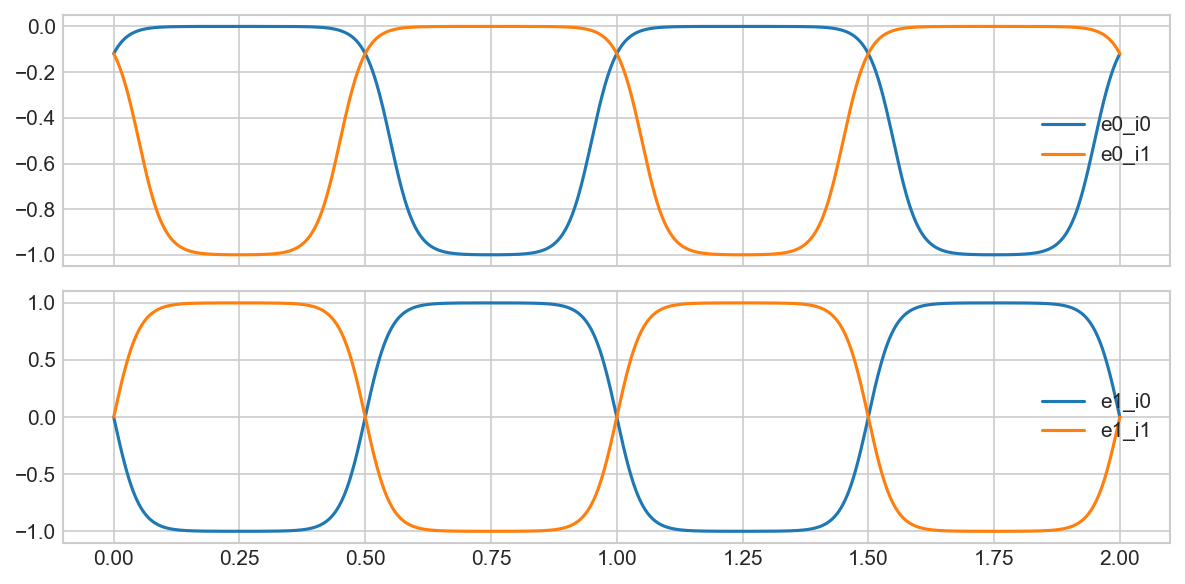

In [5]:
from phase_indication import phaseIndicatorPair
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

t = np.linspace(0, 2, 1000)

phase_indicator_pair_0 = phaseIndicatorPair(a=0.3, b=0.7, s=0.05, t0=0.25, t1=0.75, ys = -1., y0=0.)
phase_indicator_pair_1 = phaseIndicatorPair(a=0.25, b=0.75, s=0.05, t0=0.25, t1=0.75, ys = 2., y0=-1.)

e0_i0, e0_i1 = phase_indicator_pair_0.get(t)
e1_i0, e1_i1 = phase_indicator_pair_1.get(t)

fig, ax = plt.subplots(2, 1, figsize=(8, 4), dpi=75,sharex=True)
ax[0].plot(t, e0_i0, label="e0_i0")
ax[0].plot(t, e0_i1, label="e0_i1")
ax[1].plot(t, e1_i0, label="e1_i0")
ax[1].plot(t, e1_i1, label="e1_i1")

# ax[0].plot([a, a], [0, 1], '--', label='a')
# ax[0].plot([b, b], [0, 1], '--', label='b')

ax[0].legend(loc='best', frameon=False)
ax[1].legend(loc='best', frameon=False)

plt.tight_layout()
# plt.savefig("phase_indicator.svg")

In [ ]:
def exampleCycilcActionOneStep(i0,i1):
    pi = np.pi
    p_f_b0 = pi/24 # font arm body-0
    p_f_01 = pi/3 # front arm 01
    p_f_12 = -pi/12 # front arm 12
    p_b0_base = pi/8 # back leg body-0

    p_bl_b0 =p_b0_base+i0*0.08
    p_br_b0 =p_b0_base+i1*0.08

    p_bl_01 = -p_bl_b0*2
    p_br_01 = -p_br_b0*2

    p_bl_12 = p_bl_b0
    p_br_12 = p_br_b0

    joint_pos = np.array([
        # front left
            -p_f_b0,
            -p_f_01,
            -p_f_12,
        # front right
            p_f_b0,
            p_f_01,
            p_f_12,
        # back left
            -p_bl_b0 - i0*0.08 ,
            -p_bl_01,
            -p_bl_12,
        #back right
             p_br_b0 + i1*0.08,
             p_br_01,
             p_br_12,
    ])
    return joint_pos
    
def exampleCycilcAction(s):
    while True:
        # indicator for foot force
        i0_0,i0_1= s.phase_indicator_pair_0.get(s.t_normalized)
        # indicator for foot forward displacemnt relative to body, input to the example gait generator
        i1_0,i1_1= s.phase_indicator_pair_1.get(s.t_normalized) 
        joint_pos_desired = exampleCycilcAction(i1_0,i1_1)
        delta_p = 1*(joint_pos_desired-env.joint_pos)
        yield delta_p

In [ ]:
s = env

t_normalized = 0.75


# indicator for foot force
i0_0,i0_1= phase_indicator_pair_0.get(t_normalized)
# indicator for foot forward displacemnt relative to body, input to the example gait generator
i1_0,i1_1= phase_indicator_pair_1.get(t_normalized) 

############
joint_pos_desired = exampleCycilcActionOneStep(i1_0,i1_1)
delta_p = 1*(joint_pos_desired-env.joint_pos)
print(f"{i1_0:.2f},{i1_1:.2f}\r")
obs,reward,done,info = env.step(delta_p)
###########


# body-space coordinate
# x: feet->head, 
# y: right->left, left parts has +y values
# z: front->back
s.graph.setJointPosArrFast(s.joint_pos)
s.graph.updateWorldTransformFast(np.eye(4))

# s.sensor_force
# when left foot is raised, left foot sensor force should be 0, 
# penalize foot force cyclically 
c0_0 = min(1,s.sensor_force[0]) # left foot, keep max at 1
c0_1 = min(1,s.sensor_force[1]) # right foot
r0_0 = c0_0*i0_0
r0_1 = c0_1*i0_1
r0 = i0_0*c0_0+i0_1*c0_1

body_space_left_foot_sensor_pos = (s.node_sensor[0]["world_transform"]@s.t_sensor)[:3,3]
body_space_right_foot_sensor_pos = (s.node_sensor[1]["world_transform"]@s.t_sensor)[:3,3]
with np.printoptions(precision=3, suppress=True):
    print(body_space_left_foot_sensor_pos)
    print(body_space_right_foot_sensor_pos)
    
# body space left  foot sensor forward displacement / normalizaton_coefficient
c1_0 = -(s.node_sensor[0]["world_transform"]@s.t_sensor)[2,3]/100.
# body space right foot sensor forward displacement / normalizaton_coefficient
c1_1 = -(s.node_sensor[1]["world_transform"]@s.t_sensor)[2,3]/100.
print(f"c1_0, c1_1={c1_0:.3f},{c1_1:.3f}")
c1_0 = max(-1,min(1,c1_0)) # clamp to [-1,1]
c1_1 = max(-1,min(1,c1_1)) # clamp to [-1,1]
r1_0 = i1_0*c1_0
r1_1 = i1_1*c1_1
r1 = i1_0*c1_0+i1_1*c1_1

# indicator 0
print(f"i0_0, i0_1={i0_0:.3f}, {i0_1:.3f}")
print(f"c0_0, c0_1={c0_0:.3f}, {c0_1:.3f}")
print(f"r0_0, r0_1={r0_0:.3f}, {r0_1:.3f}")
print(f"r0={r0:+5.3f}")

# indicator 1
print(f"i1_0, i1_1={i1_0:+5.3f}, {i1_1:+5.3f}")
print(f"c1_0, c1_1={c1_0:+5.3f},{c1_1:+5.3f} (clamp to [-1,1])")
print(f"r1_0, r1_1={r1_0:+5.3f}, {r1_1:+5.3f}")
print(f"r1={r1:+5.3f}")

In [ ]:
obs = env.reset()
obs,reward,done,info = env.step()
while True:
    t = info['t']
    t_normalized = ((t-env.episode_start_time)*1.5)%1
    c0,c1= phase_indicator_pair_1.get(t_normalized)
    delta_p = exampleCycilcAction(c0,c1)
#     print(f"{c0:.2f},{c1:.2f}\r")
    obs,reward,done,info = env.step(delta_p)

In [ ]:
obs = env.reset()
obs,reward,done,info = env.step()


pi = np.pi

p_f_b0 = pi/24 # font arm body-0
# p_f_b0 = 0 # font arm body-0
p_f_01 = pi/3 # front arm 01
p_f_12 = -pi/12 # front arm 12

p_bl_b0 = pi/12 # back leg left body-0
p_br_b0 = pi/12 # back leg right body-0

p_b0_base = pi/8


while True:
    t = info['t']
    t_normalized = ((t-env.episode_start_time)*1.5)%1
#     c0 = np.sin(t_normalized*pi*2)
#     c1 = np.cos(t_normalized*pi*2)
    c0,c1= phase_indicator_pair_1.get(t_normalized)
    p_bl_b0 =p_b0_base+c0*0.08
    p_br_b0 =p_b0_base+c1*0.08
    
    p_bl_01 = -p_bl_b0*2
    p_br_01 = -p_br_b0*2

    p_bl_12 = p_bl_b0
    p_br_12 = p_br_b0
    
    joint_pos = np.array([
        # front left
            -p_f_b0,
            -p_f_01,
            -p_f_12,
        # front right
            p_f_b0,
            p_f_01,
            p_f_12,
        # back left
            -p_bl_b0 - c0*0.08 ,
            -p_bl_01,
            -p_bl_12,
        #back right
             p_br_b0 + c1*0.08,
             p_br_01,
             p_br_12,
    ])
    delta_p = 1*(joint_pos-env.joint_pos)
    
    print(f"{c0:.2f},{c1:.2f}\r")

    obs,reward,done,info = env.step(delta_p)

In [5]:
s = env

ID = s.ID

OBS_DICT = { # dictionary is ordered since python 3.6
    "joint_pos":None,            #0
    "joint_vel":None,            #1
    "actuation":None,            #2
    "orientation":None,          #3
    "ang_vel":None,              #4
    "com_acc":None,              #5
    "com_vel":None,              #6
    "com_pos":(2,),              #7
    "constraint":(9,12),         #8
    "spring_strain":None,        #9
}

for key in list(OBS_DICT): # remove item with zero size
    if s.REC["size"][s.ID[key]]==0:
        print(f"{key} size==0, removed from OBS_DICT")
        OBS_DICT.pop(key)

OBS_NAME = tuple(OBS_DICT.keys()) # keys in OBS_DICT
OBS_IDS = tuple(ID[n] for n in OBS_NAME) # indices of the OBS
OBS_ITEM_SLICE = tuple(OBS_DICT.values()) # indices of each item in OBS_DICT

msg = env.receive()

spring_strain size==0, removed from OBS_DICT


In [7]:
msg_rec_i = msg[0]
# measured normalized constraint force
s.sensor_force = itemgetter(*s.sensor_id)(msg_rec_i[s.ID_constraint])

In [9]:
s.sensor_force

(0.08275821059942245, 0.08181320875883102)

In [8]:
msg_rec_i

(14,
 7399.80908203125,
 (0.8661017417907715,
  0.499867707490921,
  0.49981093406677246,
  -0.866134524345398,
  0.5000045299530029,
  0.8660228252410889,
  0.8660719990730286,
  -0.4999193251132965,
  0.4997863471508026,
  0.8661487102508545,
  0.5000131130218506,
  -0.8660178780555725,
  0.9659333825111389,
  -0.25879091024398804,
  0.8660332560539246,
  0.4999864399433136,
  0.965925395488739,
  -0.2588205635547638,
  0.9659333825111389,
  0.25879091024398804,
  0.8660305142402649,
  -0.49999117851257324,
  0.9659265279769897,
  0.25881633162498474),
 (3.024987760280595e-10,
  1.5876189252139739e-10,
  8.27486204557637e-11,
  -3.1331271799217575e-08,
  -1.7893242443278723e-08,
  -3.286459815399212e-08,
  1.6838382901548932e-12,
  -7.697546593188331e-12,
  6.161737786669619e-12,
  -5.551115123125783e-14,
  -9.547918011776346e-12,
  -1.1657341758564144e-12),
 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 (-5.607558364317811e-07,
  2.0264843669792754e-07,
  1.0,
  -9.

In [78]:
msg_i = msg[0]

In [29]:
def item_to_tuple(item,item_slice):
    if isinstance(item, tuple):
        if item_slice:
            sliced = itemgetter(*item_slice)(item)
            if len(item_slice)==1:
                return (sliced,)
            return sliced
        return item 
    return (item,)

In [93]:
[item_to_tuple(item,item_slice) for item,item_slice in zip(itemgetter(*OBS_IDS)(msg_i),OBS_ITEM_SLICE)]

[(0.8661125302314758,
  0.4998490810394287,
  0.4998236298561096,
  -0.8661271929740906,
  0.49999552965164185,
  0.8660280108451843,
  0.866081953048706,
  -0.49990203976631165,
  0.49981021881103516,
  0.8661349415779114,
  0.49999573826789856,
  -0.8660278916358948,
  0.9134500026702881,
  -0.406950980424881,
  0.8659651279449463,
  0.5001044273376465,
  0.9658846855163574,
  -0.2589726150035858,
  0.9134955406188965,
  0.4068486988544464,
  0.8659641146659851,
  -0.5001062154769897,
  0.9658825397491455,
  0.2589806020259857),
 (1.4597952846528983e-09,
  -2.8792449313641555e-08,
  -4.480416038177282e-09,
  -1.6403397751219018e-08,
  7.564615600585967e-09,
  -9.214924823197634e-09,
  2.8758816483787086e-07,
  3.374992729732185e-08,
  -2.7092717402865674e-08,
  -2.3512018287874525e-07,
  -4.726770796992241e-08,
  3.0881039947416866e-08),
 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 (0.1678144335746765,
  6.458018469857052e-05,
  0.98581862449646,
  -0.0002781042130

In [65]:
msg_i = msg[0]
%timeit _ = 

459 ns ± 5.53 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [23]:
from itertools import chain

In [26]:
_ = chain.from_iterable(chain.from_iterable(v if item_slice is None else itemgetter(*item_slice)(v) for v,item_slice in zip(itemgetter(*OBS_IDS)(msg_i),OBS_ITEM_SLICE)) for msg_i in msg)
list(_)

TypeError: 'float' object is not iterable

In [75]:

# itemgetter(*OBS_IDS)(msg_i)

In [28]:
[v if item_slice is None else itemgetter(*item_slice)(v) for v,item_slice in zip(itemgetter(*OBS_IDS)(msg_i),OBS_ITEM_SLICE)]

[(0.8661125302314758,
  0.4998490810394287,
  0.4998236298561096,
  -0.8661271929740906,
  0.49999552965164185,
  0.8660280108451843,
  0.866081953048706,
  -0.49990203976631165,
  0.49981021881103516,
  0.8661349415779114,
  0.49999573826789856,
  -0.8660278916358948,
  0.9134500026702881,
  -0.406950980424881,
  0.8659651279449463,
  0.5001044273376465,
  0.9658846855163574,
  -0.2589726150035858,
  0.9134955406188965,
  0.4068486988544464,
  0.8659641146659851,
  -0.5001062154769897,
  0.9658825397491455,
  0.2589806020259857),
 (-1.8013331271049537e-08,
  4.754434002052221e-08,
  -2.0381474286068624e-09,
  3.154002925498389e-08,
  -8.21934378336664e-08,
  2.1265581295892844e-08,
  1.0886106593943623e-07,
  5.718906948004587e-08,
  -1.170263885796885e-08,
  -1.1330259042097168e-07,
  -3.927965508410125e-08,
  5.33739719088544e-09),
 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 (0.1678144931793213,
  6.458097777795047e-05,
  0.9858185648918152,
  -0.0002781100920401

In [20]:
def conditional_flatten(msg_i):
    flattend = []
    for item,item_slice in zip(itemgetter(*OBS_IDS)(msg_i),OBS_ITEM_SLICE):
        try: # check if item is not single number
            len(item) # len>1
            if item_slice is not None:
                item = itemgetter(*item_slice)(item)
            try:
                len(item) # len>1
                flattend.extend(item)# not single number
            except TypeError: # single number
                flattend.append(item) # single number
        except TypeError: # single number
            flattend.append(item)
    return flattend

In [18]:
msg_i = msg[0]

In [29]:
a = np.stack([conditional_flatten(msg_i) for msg_i in msg]).astype(np.float32)

In [25]:
s.observation_space

Box(-1.0, 1.0, (331,), float32)

In [27]:
%timeit _ =[conditional_flatten(msg_i) for msg_i in msg]

31.1 µs ± 347 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [89]:
%timeit _ = list(chain.from_iterable(itemgetter(*OBS_IDS)(msg_i)))

2.28 µs ± 27.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [70]:
np.fromiter(chain(itemgetter(*OBS_IDS)(msg_i)),np.float32)

ValueError: setting an array element with a sequence.

In [66]:
itemgetter(*OBS_IDS)(msg_i)

((0.8661125302314758,
  0.4998490810394287,
  0.4998236298561096,
  -0.8661271929740906,
  0.49999552965164185,
  0.8660280108451843,
  0.866081953048706,
  -0.49990203976631165,
  0.49981021881103516,
  0.8661349415779114,
  0.49999573826789856,
  -0.8660278916358948,
  0.9134500026702881,
  -0.406950980424881,
  0.8659651279449463,
  0.5001044273376465,
  0.9658846855163574,
  -0.2589726150035858,
  0.9134955406188965,
  0.4068486988544464,
  0.8659641146659851,
  -0.5001062154769897,
  0.9658825397491455,
  0.2589806020259857),
 (2.609517650853377e-07,
  1.83193975544782e-07,
  -4.407516485116503e-07,
  -2.2488522688490775e-07,
  -2.264454508349445e-07,
  4.985282657798962e-07,
  6.821074975960073e-07,
  1.0921471016445139e-07,
  -6.068804481174084e-08,
  -7.556215564363811e-07,
  -1.2125993009703961e-07,
  6.084697901087566e-08),
 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 (0.16781431436538696,
  6.455395487137139e-05,
  0.98581862449646,
  -0.000278116640402004

In [31]:
np.testing.assert_array_equal(a,b)

In [5]:
import operator

In [6]:
operator.concat([1,3],[3])

[1, 3, 3]

In [10]:
operator.itemgetter(2, 5)([1,2,3,4,[5],[6],7,8,9])

(3, [6])

In [63]:
a0 = np.array([0,0,0])
a1 = np.array([0,0,5])
t = a1-a0
t = t/np.linalg.norm(t)

m0 = np.array([5,6,7])
m1 = np.array([3,4,5])

v0 = m0 - a0
v0_t = v0@t*t # v0 component tangent to rotation axis
v0_n = v0 - v0_t # v0 component normal to roation axis

v1 = m1 - a0 
v1_t = v1@t*t # v1 component tangent to rotation axis
v1_n = v1 - v1_t # v1 component normal to roation axis

v01 = m1 - m0
_v01 = v01/np.linalg.norm(v01) # normalized

_v01_t = _v01@t*t
_v01_n = _v01 - _v01_t

assert(np.cross(v0,_v01)@t == np.cross(v0_n,_v01_n)@t)

Text(0.5, 1.0, 'accleration reward')

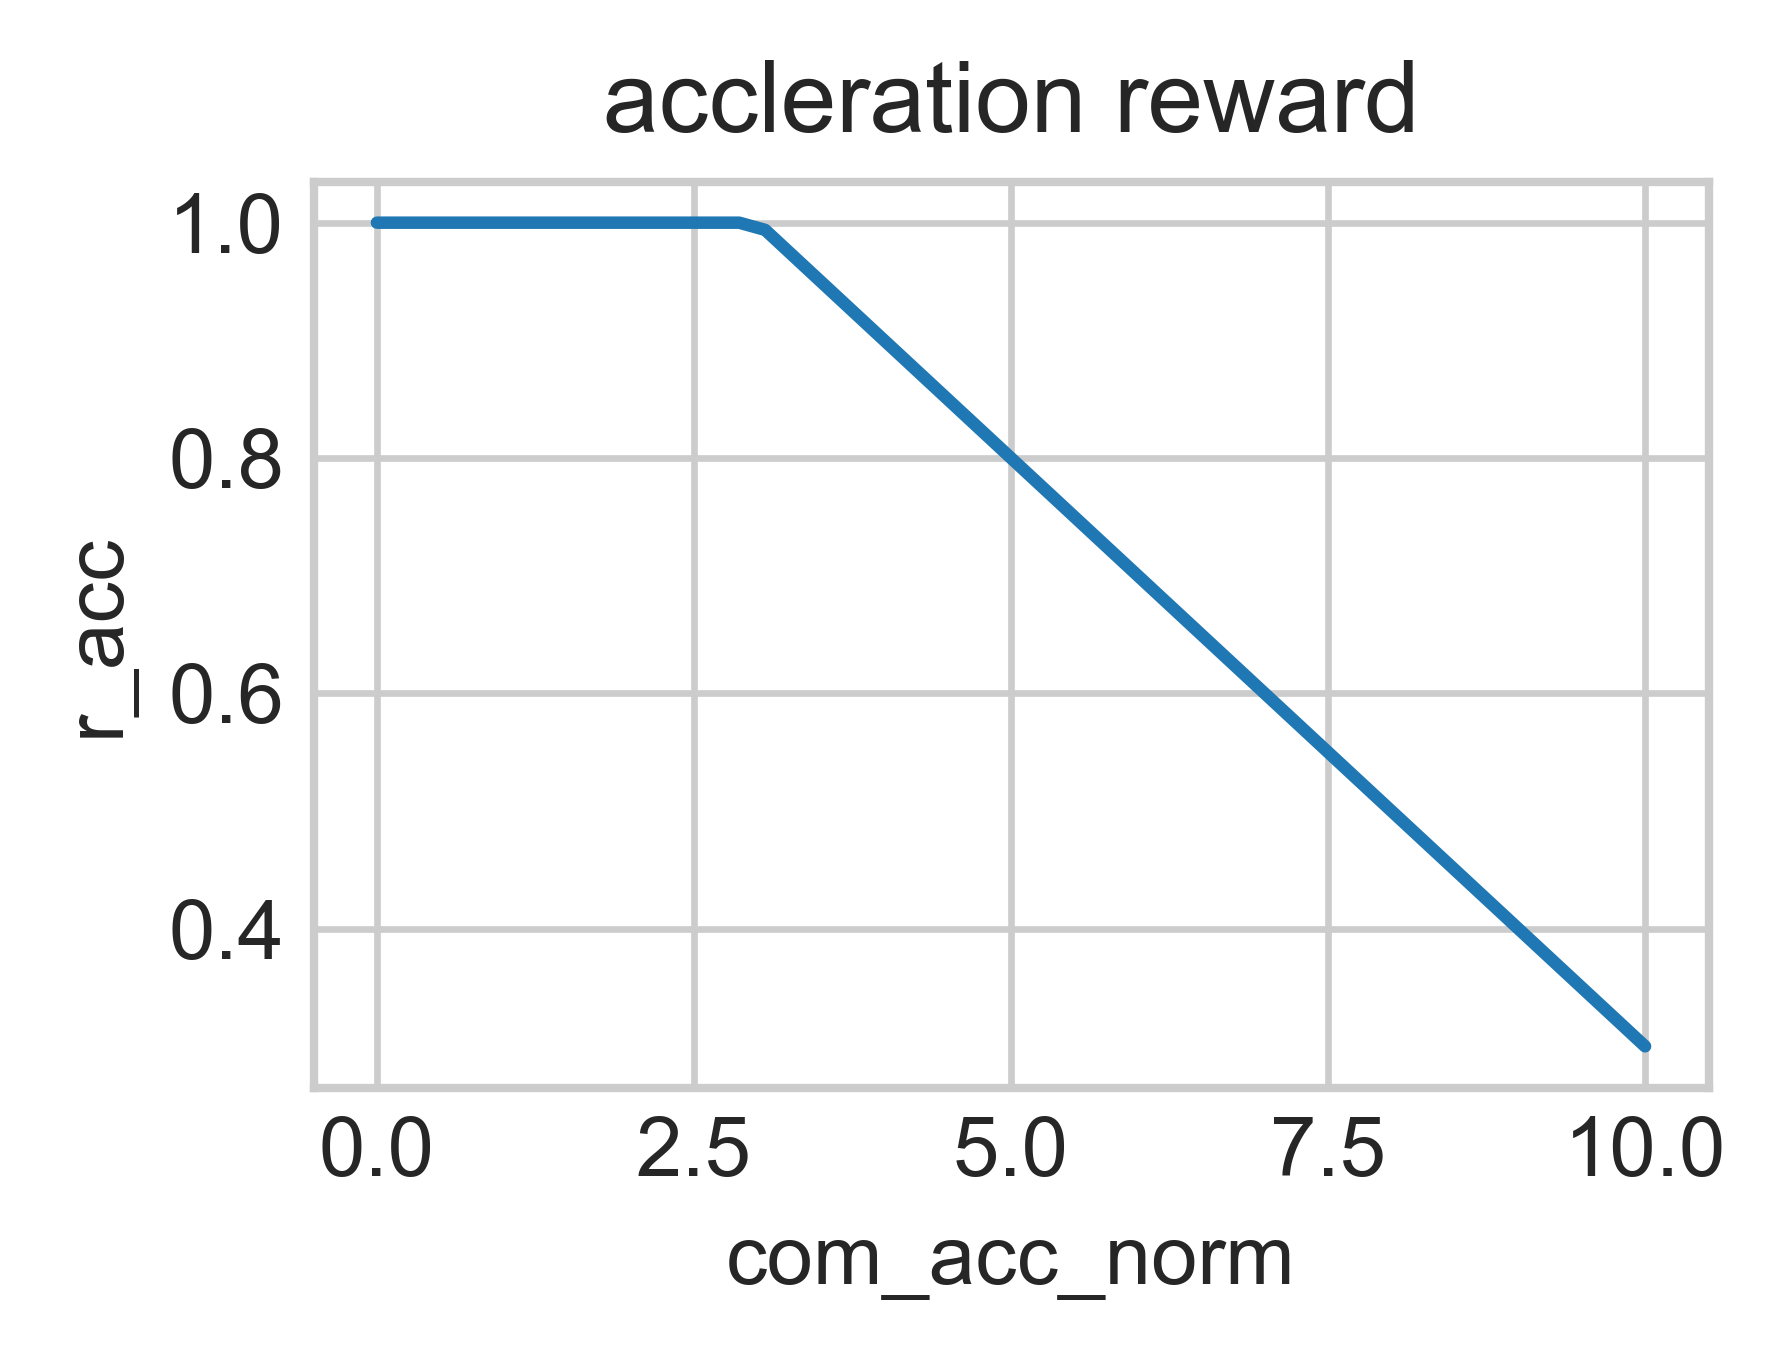

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'


com_acc_norm = np.linspace(0,10)
r_acc = np.clip(1.3-0.1*com_acc_norm,0,1)

plt.figure(dpi=300,figsize=(3,2))
plt.plot(com_acc_norm,r_acc)
plt.xlabel("com_acc_norm")
plt.ylabel("r_acc")
plt.title("accleration reward")

ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

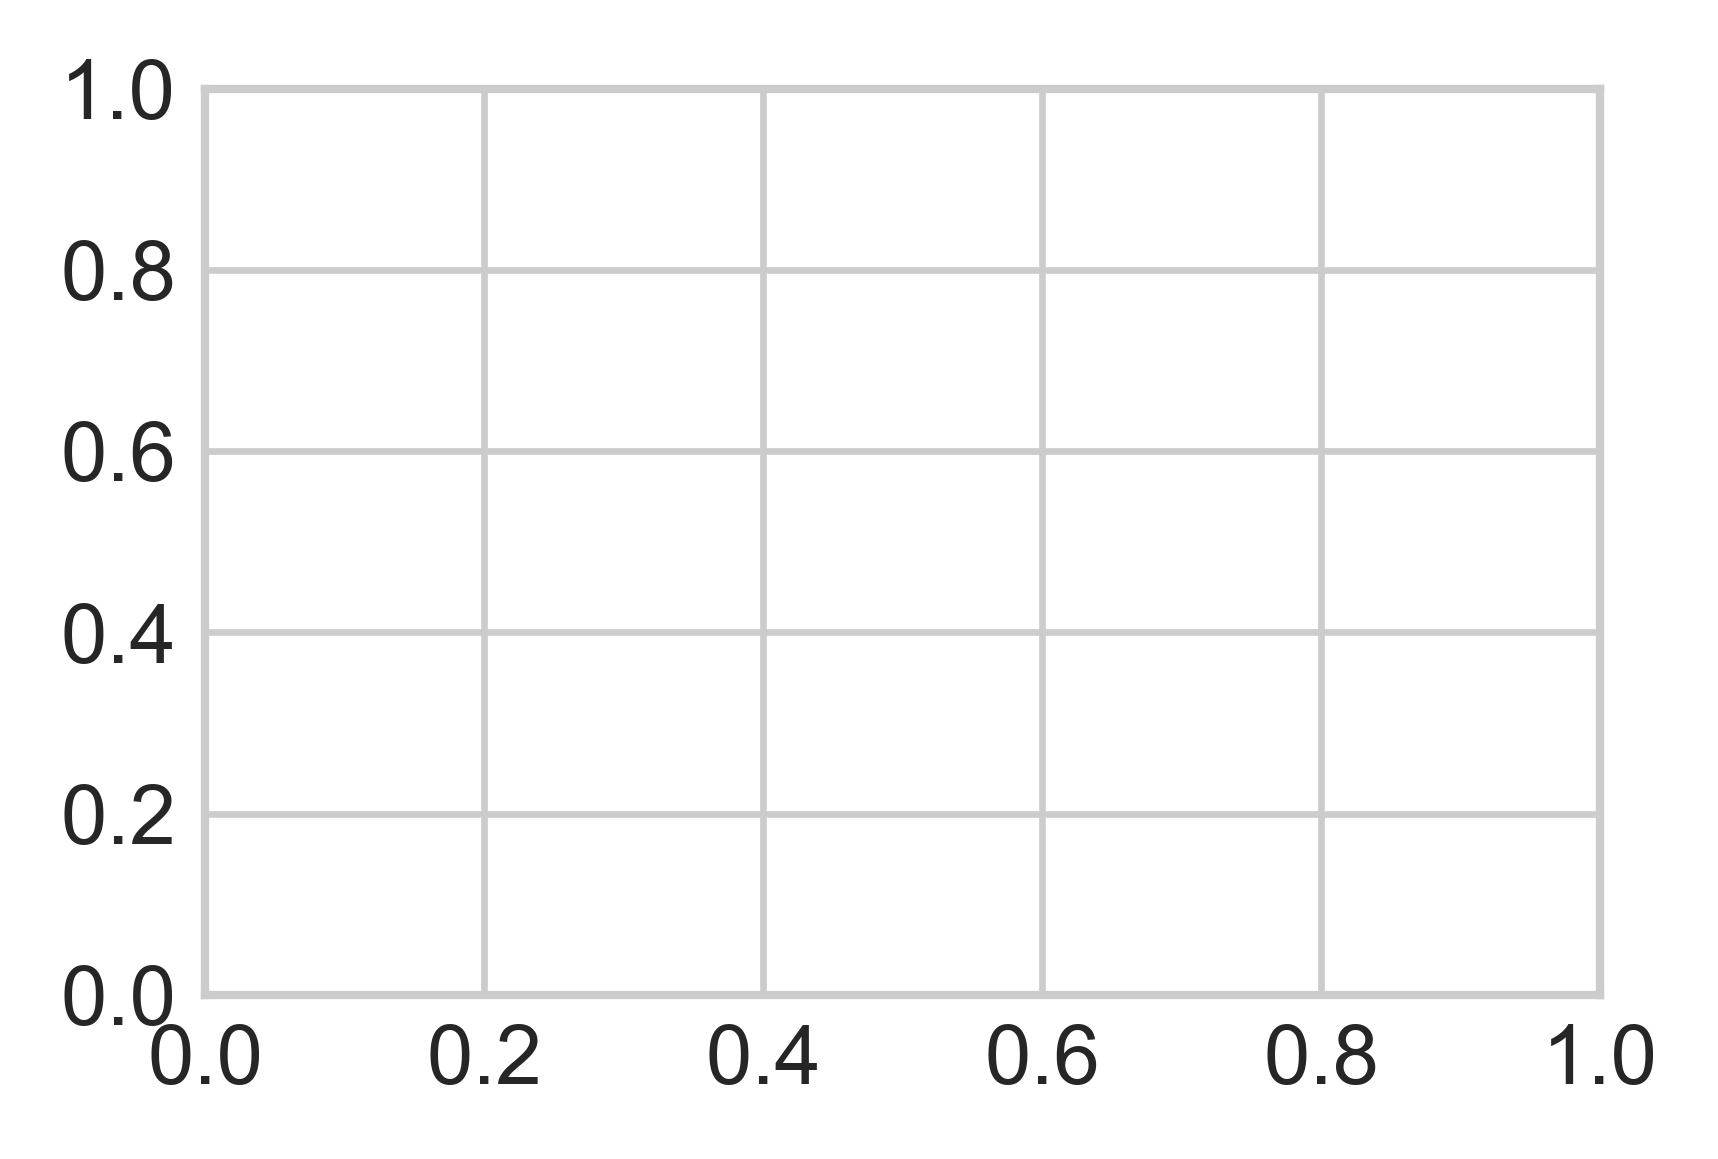

In [11]:
actuation = np.linspace(0,2)
r_quad_ctrl = max(0,1-0.05 * sum(np.square(actuation)))

plt.figure(dpi=300,figsize=(3,2))
plt.plot(actuation,r_quad_ctrl)
plt.xlabel("com_acc_norm")
plt.ylabel("r_acc")
plt.title("accleration reward")

In [13]:
import numpy as np
obs_shape = 300
action_shape = 10
buffer_size = int(1e6)

In [14]:
from cpprb import ReplayBuffer

In [18]:
env_dict = {"obs":{"shape": obs_shape},
            "act":{"shape": action_shape,"dtype": np.float32},
            "rew": {},
            "next_obs": {"shape": obs_shape},
            "done": {}}

rb = ReplayBuffer(buffer_size,env_dict)
rb.add(
    obs=np.random.rand(buffer_size,obs_shape),
    act=np.random.rand(buffer_size,action_shape),
    rew=np.random.rand(buffer_size),
    next_obs=np.random.rand(buffer_size,obs_shape),
    done = np.random.rand(buffer_size)
)

0

In [19]:
rb.get_next_index()

0

In [10]:
%timeit _ = rb.sample(1024)

2.24 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
rb.save_transitions("./test_transitions",safe=False)

In [3]:
import pytorch_sac.replay_buffer

In [12]:
rb2 = pytorch_sac.replay_buffer.ReplayBuffer(buffer_size,obs_shape=obs_shape,action_shape=action_shape,obs_dtype="float32")

In [8]:
rb2.full = True

In [9]:
%timeit _ = rb2.sample(1024)

2.89 ms ± 517 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
from pytorch_sac.replay_buffer import RecordArray
import numpy as np

class ReplayBuffer(object):
    """Buffer to store environment transitions."""

    def __init__(s, # self
                 capacity: int,  # total number of sample
                 obs_shape: tuple,  # observation shape
                 action_shape: tuple,  # action shape
                 obs_dtype: type = np.float32,  # observation dtype
                 action_dtype: type = np.float32,  # action dtype
                 device="cpu",  # cpu, cuda, cuda:0, etc.
                 chunk_bytes = 2e7 # num bytes per chunk
                 ):
        capacity = int(capacity)
        s.capacity = capacity
        s.device = device

        s.idx = 0
        s.full = False
        s.num_recent = -1  # int, most recent samples for updating
        #print(capacity,obs_shape,obs_dtype,chunk_bytes)
        # the proprioceptive obs is stored as float32, pixels obs as uint8
        #obs_dtype = np.float32 if len(obs_shape) == 1 else np.uint8        
        s.obses =      RecordArray(capacity,obs_shape,obs_dtype,chunk_bytes)
        s.next_obses = RecordArray(capacity,obs_shape,obs_dtype,chunk_bytes)
        s.actions =    RecordArray(capacity,action_shape,action_dtype,chunk_bytes)
        s.rewards =    RecordArray(capacity,(1,),np.float32,chunk_bytes)
        s.not_dones =  RecordArray(capacity,(1,),np.float32,chunk_bytes)
        s.not_dones_no_max = RecordArray(capacity,(1,),np.float32,chunk_bytes)

    def __len__(s):
        return s.capacity if s.full else s.idx

    def add(s, obs, action, reward, next_obs, done, done_no_max):
        """ add one sample """
        s.obses[s.idx] = obs
        s.actions[s.idx] = action
        s.rewards[s.idx] = reward
        s.next_obses[s.idx] = next_obs
        s.not_dones[s.idx] = not done
        s.not_dones_no_max[s.idx] = not done_no_max

        s.idx = (s.idx + 1) % s.capacity
        s.full = s.full or s.idx == 0

    def sample(s, batch_size):
        """
        sample batch_size samples from the most recent num_recent samples
        return obses, actions, rewards, next_obses, not_dones, not_dones_no_max
        """
        idx_end = s.idx
        if s.num_recent > batch_size:
            idx_begin = s.idx - s.num_recent
            s.num_recent = -1  # reset num_recent
        else:
            idx_begin = s.idx - s.capacity
        if not s.full:
            idx_begin = max(idx_begin, 0)
            
        #print(idx_begin, idx_end, batch_size)
        idxs = np.random.randint(idx_begin, idx_end, size=batch_size)
        obses = torch.as_tensor(s.obses[idxs], device=s.device)
        actions = torch.as_tensor(s.actions[idxs], device=s.device)
        rewards = torch.as_tensor(s.rewards[idxs], device=s.device)
        next_obses = torch.as_tensor(s.next_obses[idxs], device=s.device)
        not_dones = torch.as_tensor(s.not_dones[idxs], device=s.device)
        not_dones_no_max = torch.as_tensor(s.not_dones_no_max[idxs], device=s.device)
        return obses, actions, rewards, next_obses, not_dones, not_dones_no_max

    def __sizeof__(s):
        """to estimate the size in memory in bytes"""
        return super().__sizeof__()+s.obses.__sizeof__() +\
            s.next_obses.__sizeof__()+s.actions.__sizeof__() +\
            s.rewards.__sizeof__()+s.not_dones.__sizeof__() + \
            s.not_dones_no_max.__sizeof__()

    def save(s,dir_path):
        """ save replay buffer to directory path dir_path"""
        dir_path = os.path.abspath(dir_path) # convert to absolute path
        try:os.mkdir(dir_path)
        except OSError:pass
        print(f"saving replay buffer to {dir_path}")
        s.obses.save(os.path.join(dir_path,"obses"))
        s.next_obses.save(os.path.join(dir_path,"next_obses"))
        s.actions.save(os.path.join(dir_path,"actions"))
        s.rewards.save(os.path.join(dir_path,"rewards"))
        s.not_dones.save(os.path.join(dir_path,"not_dones"))
        s.not_dones_no_max.save(os.path.join(dir_path,"not_dones_no_max"))
        with open(os.path.join(dir_path,"header.msgpack"), 'wb') as file:
            msgpack.pack((s.capacity,s.idx,s.full), file)

    def load(s,dir_path):
        """load replay buffer from directory path dir_path"""
        dir_path = os.path.abspath(dir_path) # convert to absolute path
        s.obses.load(os.path.join(dir_path,"obses"))
        s.next_obses.load(os.path.join(dir_path,"next_obses"))
        s.actions.load(os.path.join(dir_path,"actions"))
        s.rewards.load(os.path.join(dir_path,"rewards"))
        s.not_dones.load(os.path.join(dir_path,"not_dones"))
        s.not_dones_no_max.load(os.path.join(dir_path,"not_dones_no_max"))
        with open(os.path.join(dir_path,"header.msgpack"), 'rb') as file:
            s.capacity,s.idx,s.full = msgpack.unpack(file)

In [21]:
float(not True)

0.0